# 0线性回归的手动实现

epoch 1, loss 0.049398
epoch 2, loss 0.000206
epoch 3, loss 0.000051
w的估计误差: tensor([-0.0003, -0.0014], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


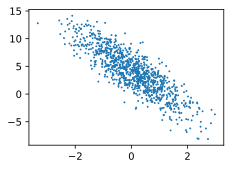

In [2]:
%matplotlib inline 
import random
import torch
from d2l import torch as d2l


#FUN1 根据已知的线性关系生成初始样本数据：：：X就表示features, y表示labels
def synthetic_data(w, b, num_examples):  #@save num_example表示像本数目
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))#X为(num_examples, len(w))的张量
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))#reshape(-1,1)代表将二维数组重整为一个一列的二维数组


#FUN2 采用小批量随机梯度对数据特征进行提取
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # yield就是return返回一个值，并且记住返回的位置，下次迭代就从这个位置后开始


# 定义模型

def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 定义优化算法 更新w和b
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            
           # print(param.grad)
            param -= lr * param.grad / batch_size
            #print(param.grad)
            param.grad.zero_()
            
# params（待优化的参数）            
# lr :学习率（步长）        
# with torch.no_grad()上下文管理器执行参数更新过程，不会对梯度计算进行跟踪。这样做可以节省内存和计算资源，因为在此步骤中仅需要更新参数，而不需要计算梯度。
# 对于每个参数，通过将学习率（lr）、参数梯度（param.grad）和批量大小的倒数（1 / batch_size）的乘积减去参数值，来更新参数。这一步实现了梯度下降更新。
# sgd随机梯度下降（Stochastic Gradient Descent，SGD）用于更新参数，不用return


# param.grad / batch_size：首先，将参数的梯度除以批量大小，得到平均梯度。这是因为在小批量随机梯度下降中，梯度的计算是基于一部分样本的，所以需要对梯度进行平均，以获得更准确的梯度估计。

# lr * (param.grad / batch_size)：然后，将平均梯度乘以学习率。这一步决定了参数更新的幅度。学习率乘以梯度将确定参数更新的方向和大小。

# param -= lr * (param.grad / batch_size)：最后，将参数值减去上一步计算得到的结果。这一步实际上是将参数朝着梯度方向更新，并且更新的幅度由学习率和平均梯度决定。


#训练

lr = 0.03
num_epochs = 3 # 迭代周期个数
net = linreg  # 函数换名
loss = squared_loss     # 函数换名


#设定初始已知的w和b，得到该线性关系附近的一批数据集
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);


        
# 正式开始建立模型  重新设置初始的w和b，此时我们需要通过计算损失函数，使得设置的w和b尽可能接近原始的w和b

# 初始化模型参数 [在我们开始用小批量随机梯度下降优化我们的模型参数之前]， (我们需要先有一些参数)。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
batch_size =10

i=1
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):#每次10个数据batch_size =10
       # print(i)
        i=i+1
        l = loss(net(X, w, b), y)  # X和y的小批量损失 此时l为tensor，为[0.5*(y*i-yi)^2]
        #print(l)
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        #print([w,b])
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        
[w, b]   #true_w = torch.tensor([2, -3.4])  true_b = 4.2
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

# 线性回归的从零开始实现


(**将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。


%matplotlib inline  把画图嵌入notebook中

In [3]:
%matplotlib inline 
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。

**torch.normal(means, std, out=None)**


返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数。 均值means是一个张量，包含每个输出元素相关的正态分布的均值。 std是一个张量，包含每个输出元素相关的正态分布的标准差。 均值和标准差的形状不须匹配，但每个张量的元素个数须相同。

参数:

means (Tensor) – 均值

std (Tensor) – 标准差

out (Tensor) – 可选的输出张量

**torch.matmul**

是tensor的乘法，输入可以是高维的。
当输入都是二维时，就是普通的矩阵乘法，和tensor.mm函数用法相同。

当输入有多维时，把多出的一维作为batch提出来，其他部分做矩阵乘法。

In [4]:
#reshape
#reshape(-1,1)中的-1代表无意义
#reshape(-1,1)代表将二维数组重整为一个一列的二维数组
#reshape(1,-1)代表将二维数组重整为一个一行的二维数组
#reshape(-1,n)代表将二维数组重整为n列的二维数组
#reshape(n,-1)代表将二维数组重整为n行的二维数组

import numpy as np
a = np.array([[1, 2, 3, 4, 5, 6],
              [7, 8, 9, 10, 11, 12],
              [13, 14, 15, 16, 17, 18],
              [19, 20, 21, 22, 23, 24]])
# 将二维数组a转换成一个三维数组，形状为(2, 3, 4)
b = np.reshape(a, (2, 3, 4))
print(a.shape)    # 输出(4, 6)
print(b.shape)    # 输出(2, 3, 4)
print(b)


(4, 6)
(2, 3, 4)
[[[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]]

 [[13 14 15 16]
  [17 18 19 20]
  [21 22 23 24]]]


In [5]:
def synthetic_data(w, b, num_examples):  #@save num_example表示像本数目
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))#X为(num_examples, len(w))的张量
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))#reshape(-1,1)代表将二维数组重整为一个一列的二维数组

In [6]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [7]:
features

tensor([[ 0.9760, -0.1750],
        [ 0.5003,  0.7890],
        [-0.8675, -1.5021],
        ...,
        [ 0.5446, -0.7213],
        [-0.7594,  0.0311],
        [ 0.6347, -1.1989]])

In [ ]:
labels

In [9]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.9760, -0.1750]) 
label: tensor([6.7435])


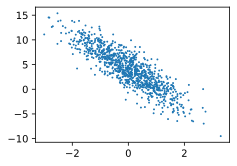

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), 
                labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。

In [11]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # yield就是return返回一个值，并且记住返回的位置，下次迭代就从这个位置后开始

batch_indices 是一个包含当前批次样本索引的 PyTorch 张量。这个张量记录了从整个数据集中随机选择的一批样本的索引。

features[batch_indices]：这是通过使用批次索引从整个特征数据集 features 中选择出当前批次的特征。features[batch_indices] 返回一个包含当前批次特征的 PyTorch 张量。

labels[batch_indices]：同样，这是通过使用批次索引从整个标签数据集 labels 中选择出当前批次的标签。labels[batch_indices] 返回一个包含当前批次标签的 PyTorch 张量。

yield features[batch_indices], labels[batch_indices]：这是使用 yield 语句将当前批次的特征和标签作为一组数据产生出来。这并不是返回一个完整的数据集，而是创建了一个生成器对象，可以在迭代中逐批次地获取数据。

yield就是return返回一个值，并且记住返回的位置，下次迭代就从这个位置后开始


In [ ]:

batch_size =10


for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)

当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。



# 重新设置初始的w和b，此时我们需要通过计算损失函数，使得设置的w和b尽可能接近原始的w和b

In [13]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。 因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。 我们使用 :numref:sec_autograd中引入的自动微分来计算梯度。


## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下 :numref:`subsec_broadcasting`中描述的广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [14]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。

In [15]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


lr :学习率（步长）


In [16]:

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            # print(param.grad)
            param.grad.zero_()
            
# params（待优化的参数）            
# lr :学习率（步长）        
# with torch.no_grad()上下文管理器执行参数更新过程，不会对梯度计算进行跟踪。这样做可以节省内存和计算资源，因为在此步骤中仅需要更新参数，而不需要计算梯度。
# 对于每个参数，通过将学习率（lr）、参数梯度（param.grad）和批量大小的倒数（1 / batch_size）的乘积减去参数值，来更新参数。这一步实现了梯度下降更新。
# sgd随机梯度下降（Stochastic Gradient Descent，SGD）用于更新参数，不用return


# param.grad / batch_size：首先，将参数的梯度除以批量大小，得到平均梯度。这是因为在小批量随机梯度下降中，梯度的计算是基于一部分样本的，所以需要对梯度进行平均，以获得更准确的梯度估计。

# lr * (param.grad / batch_size)：然后，将平均梯度乘以学习率。这一步决定了参数更新的幅度。学习率乘以梯度将确定参数更新的方向和大小。

# param -= lr * (param.grad / batch_size)：最后，将参数值减去上一步计算得到的结果。这一步实际上是将参数朝着梯度方向更新，并且更新的幅度由学习率和平均梯度决定。

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization`中详细介绍。

In [17]:
lr = 0.03
num_epochs = 3 # 迭代周期个数
net = linreg  # 函数换名
loss = squared_loss     # 函数换名

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043519
epoch 2, loss 0.000182
epoch 3, loss 0.000057


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。

In [18]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0004, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

# 1线性回归的简洁实现

In [19]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l


true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)


def load_array(data_arrays,batch_size,is_train=True):
    """构造一个Pytorch的数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)


"""
# dataset 一个tensor,用来保存(features,labels)，即所谓的dataarray。创建一个TensorDataset对象，该对象将特征和标签组合成一个数据集。
# data_arrays参数中的*表示解包操作，将data_arrays中的元素分别传递给TensorDataset。
# shuffle 随机打乱
使用data.DataLoader(dataset, batch_size, shuffle=is_train)构建一个数据加载器（DataLoader）对象。
数据加载器是PyTorch提供的一个工具，用于将数据集按照指定的批量大小进行分批，并提供迭代器的功能。
dataset参数是前面创建的TensorDataset对象，batch_size参数指定每个小批量的样本数量，
"""

batch_size=10
data_iter =load_array((features,labels),batch_size) # 返回的结果赋值给data_iter，表示得到了一个数据迭代器对象。
next(iter(data_iter))  ## 这里使用iter(data_iter)将数据迭代器转换为可迭代对象，然后使用next()函数获取下一个批量数据。





[tensor([[ 0.6618,  0.9022],
         [-1.6435, -0.4623],
         [ 0.8738,  0.6583],
         [ 0.4727, -0.6650],
         [ 0.4655, -0.7301],
         [ 0.4582,  0.7183],
         [ 1.8946, -0.4719],
         [-0.3781, -0.6873],
         [ 1.7477,  1.7110],
         [-0.2589, -0.5401]]),
 tensor([[2.4589],
         [2.4772],
         [3.7077],
         [7.4158],
         [7.6014],
         [2.6862],
         [9.5951],
         [5.7745],
         [1.8859],
         [5.5306]])]

In [20]:
"""使用框架定义好的层"""
from torch import nn              # nn表示神经网络的缩写
net =nn.Sequential(nn.Linear(2,1)) # Sequential:相当于list of layers，把所有层按顺序放在一起
"""
通过nn.Linear(2, 1)创建了一个线性层（Linear Layer），并将其作为参数传递给nn.Sequential。
nn.Linear(2, 1)表示创建一个线性层，输入特征的维度为2，输出特征的维度为1。
nn.Sequential是PyTorch提供的一个容器，可以将多个神经网络层按顺序组合在一起，形成一个神经网络模型。
"""

"""使用框架定义好的层"""
net[0].weight.data.normal_(0,0.01)  #normal_:noraml 加下划线_表示用(0,0.01)的正态分布替换data的值
net[0].bias.data.fill_(0)
"""
在这里，net[0]表示访问神经网络模型中的第一个层，即线性层。
net[0].weight表示线性层的权重参数，net[0].bias表示线性层的偏置参数。
data属性表示参数的数据，可以通过它来访问和修改参数的值。
normal_(0, 0.01)是一个方法调用，表示对权重参数进行正态分布的随机初始化，均值为0，标准差为0.01。这个操作将会改变权重参数的值。
fill_(0)是一个方法调用，表示将偏置参数的值填充为0。这个操作将会改变偏置参数的值。
"""

'\n在这里，net[0]表示访问神经网络模型中的第一个层，即线性层。\nnet[0].weight表示线性层的权重参数，net[0].bias表示线性层的偏置参数。\ndata属性表示参数的数据，可以通过它来访问和修改参数的值。\nnormal_(0, 0.01)是一个方法调用，表示对权重参数进行正态分布的随机初始化，均值为0，标准差为0.01。这个操作将会改变权重参数的值。\nfill_(0)是一个方法调用，表示将偏置参数的值填充为0。这个操作将会改变偏置参数的值。\n'

数据集（Dataset）：数据集是存储样本和标签的容器，用于提供数据给迭代器。在PyTorch中，常用的数据集类是torch.utils.data.TensorDataset，它可以将特征和标签组合成一个数据集对象。

数据加载器（DataLoader）：数据加载器是数据迭代器的主要组件，负责管理数据集的加载和分批处理。torch.utils.data.DataLoader类提供了数据加载器的功能，可以指定批量大小、是否打乱数据、并行加载等参数。